# Task 2 — Classical ML vs LLMs on Structured Data (Iris)

**Date:** 2026-01-31

This notebook solves **Task 2** end-to-end on the Iris dataset and compares: 
- A **classical tree-based model** (Random Forest + an interpretable Decision Tree for rules)
- A **Transformer classifier** trained on two **textified** versions of the same structured rows
- A **local LLM** (few-shot prompting) used as a predictor, **with and without** structured guidance from the classical model

The goal is not state-of-the-art performance; it is to analyze modeling paradigms, limitations, interpretability, robustness, and practical choice tradeoffs.

## Environment & setup
This repo includes an `environment.yml` intended for `mamba`:

```bash
mamba env create -f environment.yml
mamba activate llm_structured_data
python -m ipykernel install --user --name llm_structured_data --display-name "Python (llm_structured_data)"
```

Notes:
- This notebook uses `sklearn.datasets.load_iris` (canonical Iris). If you later add the Kaggle CSV under `data/`, you can adapt the loader easily.
- Transformer / LLM sections download models from Hugging Face on first run.

In [1]:
# Core imports
import os
# Allow GPU (do not hide CUDA devices).
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# Load HuggingFace token from .env (for gated models like Llama)
from dotenv import load_dotenv
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")
if HF_TOKEN:
    print("HF_TOKEN loaded from .env")
else:
    print("WARNING: HF_TOKEN not found. Gated models (e.g., Llama) will be skipped.")

import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed as hf_set_seed,
)
from datasets import Dataset

print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

HF_TOKEN loaded from .env


/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 2.4.1.post300
CUDA available: True
CUDA device: NVIDIA RTX 2000 Ada Generation Laptop GPU


In [5]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
hf_set_seed(SEED)

@dataclass
class SplitConfig:
    test_size: float = 0.2
    val_size: float = 0.2
    random_state: int = SEED

SPLIT_CFG = SplitConfig()

## Load Iris dataset (structured)
We use the canonical Iris dataset from scikit-learn (same schema as Kaggle variant):
- 4 numeric features: sepal length/width, petal length/width
- 3 classes: setosa, versicolor, virginica

In [2]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.rename(columns={"target": "label_id"}, inplace=True)
label_names = list(iris.target_names)
id_to_label = {i: name for i, name in enumerate(label_names)}
label_to_id = {v: k for k, v in id_to_label.items()}
df["label"] = df["label_id"].map(id_to_label)

feature_cols = list(iris.feature_names)
target_col = "label_id"

print('Class distribution:')
display(df['label'].value_counts())
df

Class distribution:


label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_id,label
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


## Train / validation / test split
We use **stratified** splitting to preserve class balance in each split (important with small datasets).

In [6]:
X = df[feature_cols].copy()
y = df[target_col].copy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=SPLIT_CFG.test_size, random_state=SPLIT_CFG.random_state, stratify=y
)

# val_size is relative to the remaining trainval portion
val_relative = SPLIT_CFG.val_size / (1.0 - SPLIT_CFG.test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_relative, random_state=SPLIT_CFG.random_state, stratify=y_trainval
)

print('Sizes:', {
    'train': len(X_train),
    'val': len(X_val),
    'test': len(X_test),
})

print('Train class counts:')
print(pd.Series(y_train).value_counts().sort_index())
print('Val class counts:')
print(pd.Series(y_val).value_counts().sort_index())
print('Test class counts:')
print(pd.Series(y_test).value_counts().sort_index())

Sizes: {'train': 90, 'val': 30, 'test': 30}
Train class counts:
label_id
0    30
1    30
2    30
Name: count, dtype: int64
Val class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64
Test class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64


# Task 2.1 — Classical Baseline on Structured Data
We train a **tree-based classifier** on the structured numeric features and evaluate on the held-out test set.

We use a **Random Forest** for a strong, simple baseline, and train an additional **Decision Tree** to extract human-readable rules (for later LLM augmentation).

,model,accuracy,macro_f1
0,RandomForest,0.933333,0.933333
1,RandomForest,0.933333,0.933333


Test classification report (RandomForest):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



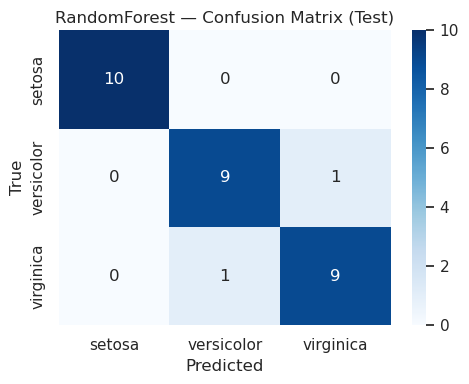

In [7]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    class_weight=None,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

def evaluate_classifier(name: str, model, X_eval: pd.DataFrame, y_eval: pd.Series) -> Dict[str, float]:
    pred = model.predict(X_eval)
    acc = accuracy_score(y_eval, pred)
    f1 = f1_score(y_eval, pred, average='macro')
    return {
        'model': name,
        'accuracy': float(acc),
        'macro_f1': float(f1),
    }

rf_val_metrics = evaluate_classifier('RandomForest', rf, X_val, y_val)
rf_test_metrics = evaluate_classifier('RandomForest', rf, X_test, y_test)
display(pd.DataFrame([rf_val_metrics, rf_test_metrics]))

rf_test_pred = rf.predict(X_test)
print('Test classification report (RandomForest):')
print(classification_report(y_test, rf_test_pred, target_names=label_names))

cm = confusion_matrix(y_test, rf_test_pred, labels=list(range(len(label_names))))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('RandomForest — Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

,importance
petal width (cm),0.465318
petal length (cm),0.397973
sepal length (cm),0.123188
sepal width (cm),0.013520


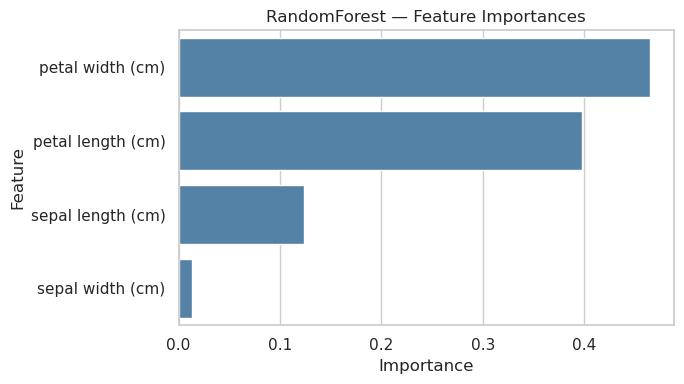

,model,accuracy,macro_f1
0,DecisionTree(max_depth=3),0.933333,0.933333


Decision tree rules (max_depth=3):
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 5.00
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  5.00
|   |   |   |--- class: 1
|   |--- petal width (cm) >  1.65
|   |   |--- class: 2

Decision tree rules (natural language, mm):
- If petal_length <= 24 mm, it is setosa.
- Else if petal_length is > 24 mm and petal_width is <= 16 mm, it is versicolor.
- Otherwise, it is virginica.


In [8]:
# Feature importance (RandomForest)
rf_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
display(rf_importances.to_frame('importance'))


plt.figure(figsize=(7, 4))
sns.barplot(x=rf_importances.values, y=rf_importances.index, color='steelblue')
plt.title('RandomForest — Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Interpretable rules: fit a small Decision Tree
dt = DecisionTreeClassifier(random_state=SEED, max_depth=3)
dt.fit(X_train, y_train)
dt_test_metrics = evaluate_classifier('DecisionTree(max_depth=3)', dt, X_test, y_test)
display(pd.DataFrame([dt_test_metrics]))


rules_text = export_text(dt, feature_names=feature_cols)
print('Decision tree rules (max_depth=3):')
print(rules_text)


# Hardcoded natural-language rules in millimeters (mm), derived from the tree above
rules_nl_mm = "\n".join([
    "- If petal_length <= 24 mm, it is setosa.",
    "- Else if petal_length is > 24 mm and petal_width is <= 16 mm, it is versicolor.",
    "- Otherwise, it is virginica.",
])


print('Decision tree rules (natural language, mm):')
print(rules_nl_mm)

### Discussion (2.1)
In the next cell we generate a brief, **data-driven** discussion based on the actual observed metrics and importances from your run.

In [9]:
top_feats = rf_importances.head(2)
print('2.1 Discussion (auto-generated)')
print('-' * 60)
print(f"Model behavior: RandomForest achieves acc={rf_test_metrics['accuracy']:.3f}, macro-F1={rf_test_metrics['macro_f1']:.3f} on test.")
print('Feature importance: top drivers by RF importance:')
for feat, imp in top_feats.items():
    print(f"  - {feat}: {imp:.3f}")
print('Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.')
print('Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.')

2.1 Discussion (auto-generated)
------------------------------------------------------------
Model behavior: RandomForest achieves acc=0.933, macro-F1=0.933 on test.
Feature importance: top drivers by RF importance:
  - petal width (cm): 0.465
  - petal length (cm): 0.398
Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.
Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.


# Task 2.2 — Textification and Transformer-Based Modeling

We convert each structured row into **two** textual forms:

1) **Natural-language description**: semantically explicit and closer to typical NLP pretraining distributions.
2) **Compact semi-structured string**: preserves numeric fidelity and reduces irrelevant tokens (closer to key=value logs/records).

We fine-tune a small Transformer classifier on each representation and compare results.

Design rationale (expected effects):
- Natural language may help the model leverage linguistic priors, but can add verbosity/noise and rounding artifacts.
- Compact text may reduce noise and preserve structure, but can be out-of-distribution vs natural language pretraining.

### Why convert cm → mm in textification?
We convert the original numeric features (centimeters) into **integer millimeters** (`mm = round(cm × 10)`) for both text formats.

Motivation:
- **Removes decimal points** (e.g., `5.1 cm` → `51 mm`), which can reduce subword tokenization fragmentation (`5`, `.`, `1`) and make the input pattern more consistent for BERT-like models.
- **Keeps the same precision** used earlier (0.1 cm), so we are not adding extra information—just re-encoding it.
- Acts as a small diagnostic: if performance changes, it suggests the prior failure was partly a **tokenization / representation** issue rather than purely “Transformers can’t do tabular data.”

In [10]:
def _cm_to_mm_int(x: float) -> int:
    # Iris features are in centimeters. Converting to integer millimeters (cm * 10)
    # preserves the original 0.1 cm precision while removing decimal points,
    # which can reduce tokenization noise for subword models like BERT.
    return int(round(float(x) * 10.0))


def _format_cm(x: float) -> str:
    return f"{float(x):.1f}"


def textify_natural_cm(row: pd.Series) -> str:
    sl = _format_cm(row[feature_cols[0]])
    sw = _format_cm(row[feature_cols[1]])
    pl = _format_cm(row[feature_cols[2]])
    pw = _format_cm(row[feature_cols[3]])
    return (
        f"An iris flower has sepal length {sl} cm, "
        f"sepal width {sw} cm, "
        f"petal length {pl} cm, "
        f"and petal width {pw} cm."
    )


def textify_compact_cm(row: pd.Series) -> str:
    sl = _format_cm(row[feature_cols[0]])
    sw = _format_cm(row[feature_cols[1]])
    pl = _format_cm(row[feature_cols[2]])
    pw = _format_cm(row[feature_cols[3]])
    return (
        f"sepal_length={sl} cm; "
        f"sepal_width={sw} cm; "
        f"petal_length={pl} cm; "
        f"petal_width={pw} cm"
    )


def textify_natural_mm(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"An iris flower has sepal length {sl} mm, "
        f"sepal width {sw} mm, "
        f"petal length {pl} mm, "
        f"and petal width {pw} mm."
    )


def textify_compact_mm(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"sepal_length={sl} mm; "
        f"sepal_width={sw} mm; "
        f"petal_length={pl} mm; "
        f"petal_width={pw} mm"
    )


def textify_natural(row: pd.Series) -> str:
    return textify_natural_mm(row)


def textify_compact(row: pd.Series) -> str:
    return textify_compact_mm(row)


def textify_natural_cm_mm(row: pd.Series) -> Tuple[str, str]:
    return textify_natural_cm(row), textify_natural_mm(row)


def textify_compact_cm_mm(row: pd.Series) -> Tuple[str, str]:
    return textify_compact_cm(row), textify_compact_mm(row)


# Preview a few examples
sample_idx = df.sample(3, random_state=SEED).index
for i in sample_idx:
    row = df.loc[i]
    print('Label:', row['label'])
    print('Natural (cm):', textify_natural_cm(row))
    print('Compact (cm):', textify_compact_cm(row))
    print('Natural (mm):', textify_natural_mm(row))
    print('Compact (mm):', textify_compact_mm(row))
    print('-' * 60)

Label: versicolor
Natural (cm): An iris flower has sepal length 6.1 cm, sepal width 2.8 cm, petal length 4.7 cm, and petal width 1.2 cm.
Compact (cm): sepal_length=6.1 cm; sepal_width=2.8 cm; petal_length=4.7 cm; petal_width=1.2 cm
Natural (mm): An iris flower has sepal length 61 mm, sepal width 28 mm, petal length 47 mm, and petal width 12 mm.
Compact (mm): sepal_length=61 mm; sepal_width=28 mm; petal_length=47 mm; petal_width=12 mm
------------------------------------------------------------
Label: setosa
Natural (cm): An iris flower has sepal length 5.7 cm, sepal width 3.8 cm, petal length 1.7 cm, and petal width 0.3 cm.
Compact (cm): sepal_length=5.7 cm; sepal_width=3.8 cm; petal_length=1.7 cm; petal_width=0.3 cm
Natural (mm): An iris flower has sepal length 57 mm, sepal width 38 mm, petal length 17 mm, and petal width 3 mm.
Compact (mm): sepal_length=57 mm; sepal_width=38 mm; petal_length=17 mm; petal_width=3 mm
------------------------------------------------------------
Label: v

In [11]:
def build_text_df(X_part: pd.DataFrame, y_part: pd.Series) -> pd.DataFrame:
    part = X_part.copy()
    part['label_id'] = y_part.values.astype(int)
    part['text_natural_cm'] = part.apply(lambda r: textify_natural_cm(r), axis=1)
    part['text_compact_cm'] = part.apply(lambda r: textify_compact_cm(r), axis=1)
    part['text_natural_mm'] = part.apply(lambda r: textify_natural_mm(r), axis=1)
    part['text_compact_mm'] = part.apply(lambda r: textify_compact_mm(r), axis=1)
    return part


train_text_df = build_text_df(X_train, y_train)
val_text_df = build_text_df(X_val, y_val)
test_text_df = build_text_df(X_test, y_test)


display(train_text_df[['text_natural_cm', 'text_compact_cm', 'text_natural_mm', 'text_compact_mm', 'label_id']].head())

,text_natural_cm,text_compact_cm,text_natural_mm,text_compact_mm,label_id
124,"An iris flower has sepal length 6.7 cm, sepal ...",sepal_length=6.7 cm; sepal_width=3.3 cm; petal...,"An iris flower has sepal length 67 mm, sepal w...",sepal_length=67 mm; sepal_width=33 mm; petal_l...,2
40,"An iris flower has sepal length 5.0 cm, sepal ...",sepal_length=5.0 cm; sepal_width=3.5 cm; petal...,"An iris flower has sepal length 50 mm, sepal w...",sepal_length=50 mm; sepal_width=35 mm; petal_l...,0
54,"An iris flower has sepal length 6.5 cm, sepal ...",sepal_length=6.5 cm; sepal_width=2.8 cm; petal...,"An iris flower has sepal length 65 mm, sepal w...",sepal_length=65 mm; sepal_width=28 mm; petal_l...,1
23,"An iris flower has sepal length 5.1 cm, sepal ...",sepal_length=5.1 cm; sepal_width=3.3 cm; petal...,"An iris flower has sepal length 51 mm, sepal w...",sepal_length=51 mm; sepal_width=33 mm; petal_l...,0
108,"An iris flower has sepal length 6.7 cm, sepal ...",sepal_length=6.7 cm; sepal_width=2.5 cm; petal...,"An iris flower has sepal length 67 mm, sepal w...",sepal_length=67 mm; sepal_width=25 mm; petal_l...,2


In [ ]:
def make_hf_dataset(df_part: pd.DataFrame, text_col: str) -> Dataset:
    return Dataset.from_dict({
        'text': df_part[text_col].tolist(),
        'labels': df_part['label_id'].astype(int).tolist(),
    })


ds_train_natural_cm = make_hf_dataset(train_text_df, 'text_natural_cm')
ds_val_natural_cm = make_hf_dataset(val_text_df, 'text_natural_cm')
ds_test_natural_cm = make_hf_dataset(test_text_df, 'text_natural_cm')


ds_train_compact_cm = make_hf_dataset(train_text_df, 'text_compact_cm')
ds_val_compact_cm = make_hf_dataset(val_text_df, 'text_compact_cm')
ds_test_compact_cm = make_hf_dataset(test_text_df, 'text_compact_cm')


ds_train_natural_mm = make_hf_dataset(train_text_df, 'text_natural_mm')
ds_val_natural_mm = make_hf_dataset(val_text_df, 'text_natural_mm')
ds_test_natural_mm = make_hf_dataset(test_text_df, 'text_natural_mm')


ds_train_compact_mm = make_hf_dataset(train_text_df, 'text_compact_mm')
ds_val_compact_mm = make_hf_dataset(val_text_df, 'text_compact_mm')
ds_test_compact_mm = make_hf_dataset(test_text_df, 'text_compact_mm')


len(ds_train_natural_cm), len(ds_val_natural_cm), len(ds_test_natural_cm)

In [ ]:
# Small default model for CPU-friendly fine-tuning (will use GPU if available)
TRANSFORMER_MODELS = ['prajjwal1/bert-tiny', 'prajjwal1/bert-mini', 'prajjwal1/bert-small']

def _short_model_name(model_name: str) -> str:
    return model_name.split('/')[-1]


def _best_eval_epoch(log_history: List[Dict[str, object]]) -> Optional[float]:
    eval_rows = [
        (entry.get('eval_loss'), entry.get('epoch'))
        for entry in log_history
        if 'eval_loss' in entry
    ]
    eval_rows = [(loss, epoch) for loss, epoch in eval_rows if loss is not None and epoch is not None]
    if not eval_rows:
        return None
    eval_rows.sort(key=lambda x: x[0])
    return float(eval_rows[0][1])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': float(accuracy_score(labels, preds)),
        'macro_f1': float(f1_score(labels, preds, average='macro')),
    }


def train_transformer_classifier(
    run_name: str,
    ds_train: Dataset,
    ds_val: Dataset,
    ds_test: Dataset,
    model_name: str,
    num_labels: int = 3,
    max_epochs: int = 24,
    lr: float = 5e-5,
    weight_decay: float = 0.01,
    batch_size: int = 16,
    early_stopping_patience: int = 2,
 ) -> Dict[str, object]:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def tok(batch):
        return tokenizer(batch['text'], truncation=True)

    ds_train_tok = ds_train.map(tok, batched=True)
    ds_val_tok = ds_val.map(tok, batched=True)
    ds_test_tok = ds_test.map(tok, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id,
    )

    args = TrainingArguments(
        output_dir=f'./.hf_runs/{run_name}',
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=max_epochs,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        logging_strategy='epoch',
        report_to=[],
        seed=SEED,
        data_seed=SEED,
    )

    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_tok,
        eval_dataset=ds_val_tok,
        processing_class=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )

    trainer.train()

    best_val_epoch = _best_eval_epoch(trainer.state.log_history)

    val_metrics = trainer.evaluate(ds_val_tok)
    test_metrics = trainer.evaluate(ds_test_tok)

    test_logits = trainer.predict(ds_test_tok).predictions
    test_pred = np.argmax(test_logits, axis=-1)
    test_true = np.array(ds_test_tok['labels'])
    cm = confusion_matrix(test_true, test_pred, labels=list(range(num_labels)))

    return {
        'run_name': run_name,
        'model_name': model_name,
        'trainer': trainer,
        'tokenizer': tokenizer,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'test_cm': cm,
        'best_val_epoch': best_val_epoch,
    }


def run_transformer_experiment(
    rep_name: str,
    ds_train: Dataset,
    ds_val: Dataset,
    ds_test: Dataset,
    model_name: str,
    max_epochs: int,
    cmap: str,
    early_stopping_patience: int = 2,
 ) -> Tuple[Dict[str, object], Dict[str, object]]:
    run_name = f"iris_{rep_name}_{_short_model_name(model_name)}"
    run = train_transformer_classifier(
        run_name=run_name,
        ds_train=ds_train,
        ds_val=ds_val,
        ds_test=ds_test,
        model_name=model_name,
        max_epochs=max_epochs,
        early_stopping_patience=early_stopping_patience,
    )
    row = {
        'representation': rep_name,
        'model': model_name,
        'val_accuracy': run['val_metrics']['eval_accuracy'],
        'val_macro_f1': run['val_metrics']['eval_macro_f1'],
        'test_accuracy': run['test_metrics']['eval_accuracy'],
        'test_macro_f1': run['test_metrics']['eval_macro_f1'],
        'best_val_epoch': run['best_val_epoch'],
    }
    plt.figure(figsize=(5, 4))
    sns.heatmap(run['test_cm'], annot=True, fmt='d', cmap=cmap, xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Transformer ({rep_name} text) — {_short_model_name(model_name)}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    return run, row

In [ ]:
# Train Transformer models (bert-tiny/mini/small) on both textifications
rep_configs = [
    {
        'name': 'natural_cm',
        'ds_train': ds_train_natural_cm,
        'ds_val': ds_val_natural_cm,
        'ds_test': ds_test_natural_cm,
        'max_epochs': 24,
        'cmap': 'Greens',
    },
    {
        'name': 'compact_cm',
        'ds_train': ds_train_compact_cm,
        'ds_val': ds_val_compact_cm,
        'ds_test': ds_test_compact_cm,
        'max_epochs': 24,
        'cmap': 'Oranges',
    },
    {
        'name': 'natural_mm',
        'ds_train': ds_train_natural_mm,
        'ds_val': ds_val_natural_mm,
        'ds_test': ds_test_natural_mm,
        'max_epochs': 24,
        'cmap': 'Greens',
    },
    {
        'name': 'compact_mm',
        'ds_train': ds_train_compact_mm,
        'ds_val': ds_val_compact_mm,
        'ds_test': ds_test_compact_mm,
        'max_epochs': 24,
        'cmap': 'Oranges',
    },
 ]


transformer_runs: List[Dict[str, object]] = []
transformer_results: List[Dict[str, object]] = []


for cfg in rep_configs:
    for model_name in TRANSFORMER_MODELS:
        run, row = run_transformer_experiment(
            rep_name=cfg['name'],
            ds_train=cfg['ds_train'],
            ds_val=cfg['ds_val'],
            ds_test=cfg['ds_test'],
            model_name=model_name,
            max_epochs=cfg['max_epochs'],
            cmap=cfg['cmap'],
        )
        transformer_runs.append({
            'representation': cfg['name'],
            'model': model_name,
            'run': run,
        })
        transformer_results.append(row)


transformer_results_df = pd.DataFrame(transformer_results)

In [ ]:
# Quick view: best model per representation
best_by_rep = (
    transformer_results_df.sort_values('test_macro_f1', ascending=False)
    .groupby('representation', as_index=False)
    .first()
    .loc[:, ['representation', 'model', 'test_accuracy', 'test_macro_f1', 'best_val_epoch']]
 )
display(best_by_rep)

In [ ]:
# Compare all Transformer runs across text representations and model sizes
comparison_df = transformer_results_df.copy()
display(comparison_df.sort_values(['model', 'representation']))


best_rep = comparison_df.sort_values('test_macro_f1', ascending=False).iloc[0]['representation']
print('Best text representation by test macro-F1:', best_rep)

# Discussion (2.2)

### BERT family models (tiny / mini / small)
- **Not all models collapse**: `bert-mini` and `bert-small` reach strong test macro-F1 (≈0.90–0.93) on several reps (notably `natural_mm` and `compact_mm`, and also `compact_cm` for `bert-small`).
- **Representation matters**: the best run by test macro-F1 is `natural_mm`, but `compact_mm` is also consistently strong for `bert-mini`/`bert-small`.
- **`bert-tiny` remains unstable**: it stays near chance on some reps, improving slightly on `natural_cm/mm` but still well below the larger models.
- **Early stopping shows different training dynamics**: best validation loss is reached between ~5–24 epochs depending on model/representation, indicating sensitivity to both model size and text format.
- **Numeric-text mismatch is mitigated, not eliminated**: mm encoding helps larger models, but tiny still struggles, suggesting capacity and tokenization both matter.
- **Takeaway**: modestly larger BERTs can learn useful decision boundaries even from textified numeric data, while the smallest model is too brittle for consistent performance.
- **TODO**: try with higher lr for `bert-tiny`.

# Task 2.3 — LLM-Based Prediction and Hybrid Modeling

We evaluate a **local LLM** in a **few-shot** prompting setup (no external APIs).

Implementation choices:
- Use a small instruction-tuned model via Hugging Face (`google/flan-t5-small` by default) for CPU-friendly inference.
- Few-shot prompting: include a small balanced set of labeled training examples.
- Ask the LLM to output a single class label and a short reason.

Hybrid augmentation: we inject structured information derived from the classical model:
- RandomForest feature importances (global)
- A shallow DecisionTree rule listing (interpretable)

We compare:
- LLM alone
- LLM + classical guidance

In [ ]:
# LLM models configuration
LLM_MODELS: List[str] = [
    'google/flan-t5-large',       # 780M params - encoder-decoder
    'meta-llama/Llama-3.2-1B-Instruct',  # Requires HuggingFace access approval
    'Qwen/Qwen2.5-1.5B-Instruct',  # 1.5B params - decoder-only
]

# Model metadata for comparison table
LLM_MODEL_PARAMS = {
    'google/flan-t5-large': 780_000_000,
    'meta-llama/Llama-3.2-1B-Instruct': 1_000_000_000,
    'Qwen/Qwen2.5-1.5B-Instruct': 1_500_000_000,
}

# Models that require HF_TOKEN (gated repos)
GATED_MODELS: set = set(['meta-llama/Llama-3.2-1B-Instruct'])  


def load_llm_model(model_name: str) -> Optional[Dict[str, object]]:
    """Load LLM with gated model handling."""
    # Check if gated model requires token
    if model_name in GATED_MODELS and not HF_TOKEN:
        print(f"SKIPPING {model_name}: requires HF_TOKEN (gated model)")
        return None
    
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Determine model type
        is_t5 = 'flan-t5' in model_name.lower() or 't5' in model_name.lower()
        
        # Common tokenizer kwargs
        tokenizer_kwargs = {'use_fast': True}
        if model_name in GATED_MODELS:
            tokenizer_kwargs['token'] = HF_TOKEN
        
        tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_kwargs)
        
        # Model loading kwargs
        model_kwargs = {}
        if model_name in GATED_MODELS:
            model_kwargs['token'] = HF_TOKEN
        
        # Use fp16 on GPU for efficiency
        if torch.cuda.is_available():
            model_kwargs['torch_dtype'] = torch.float16
        
        if is_t5:
            from transformers import AutoModelForSeq2SeqLM
            model = AutoModelForSeq2SeqLM.from_pretrained(model_name, **model_kwargs)
        else:
            from transformers import AutoModelForCausalLM
            model = AutoModelForCausalLM.from_pretrained(model_name, **model_kwargs)
            # Set pad token for causal LMs
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
        
        model = model.to(device)
        model.eval()
        
        def generate_fn(prompt: str, max_new_tokens: int = 512) -> str:
            #print('Prompt:')
            #print(prompt)
            inputs = tokenizer(
                prompt,
                return_tensors='pt',
                truncation=True,
                max_length=512,
                padding=True,
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            if is_t5 and inputs['input_ids'].shape[1] >= 512:
                print('WARNING: Prompt was truncated to 512 tokens.')
            
            with torch.inference_mode():
                out_ids = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                )
            
            # For causal LMs, skip the input tokens in output
            if not is_t5:
                out_ids = out_ids[:, inputs['input_ids'].shape[1]:]
            
            output = tokenizer.decode(out_ids[0], skip_special_tokens=True)
            #print('Model output:')
            #print(output)
            return output
        
        print(f'Loaded local LLM: {model_name} | device: {device}')
        return {
            'model_name': model_name,
            'tokenizer': tokenizer,
            'model': model,
            'device': device,
            'generate_fn': generate_fn,
            'is_t5': is_t5,
        }
    except Exception as e:
        print(f'WARNING: Could not load LLM model: {model_name}')
        print(f'Reason: {repr(e)}')
        return None

In [ ]:
def label_id_to_name(label_id: int) -> str:
    return id_to_label[int(label_id)]


def normalize_label_text(text: str) -> str:
    """Extract the predicted species from LLM output.
    
    Strategy: Look for 'Answer:' marker and extract the first word after it.
    Falls back to 'unknown' if no marker found or species not recognized.
    """
    import re
    t = text.strip().lower()
    
    # Look for "Answer:" marker and get the first word after it
    answer_match = re.search(r'answer\s*[:\-]?\s*(\w+)', t)
    if answer_match:
        first_word = answer_match.group(1)
        if first_word in label_names:
            return first_word
        
    # t5 models may output just the label without marker
    if t in label_names:
        return t
    
    return 'unknown'


def extract_reasoning(output: str) -> Tuple[str, str]:
    """Extract reasoning and final answer from model output.
    
    Returns:
        (reasoning, answer) tuple
    """
    text = output.strip()
    
    # Try to find explicit answer markers
    marker = 'answer:'
    if marker in text.lower():
        idx = text.lower().rfind(marker)
        reasoning = text[:idx].strip()
        answer_part = text[idx:].strip()
        return reasoning, answer_part
    
    # If output has multiple lines, last line is likely the answer
    lines = [l.strip() for l in text.split('\n') if l.strip()]
    if len(lines) > 1:
        reasoning = '\n'.join(lines[:-1])
        answer = lines[-1]
        return reasoning, answer
    
    # Single line output - no reasoning, just answer
    return '', text


def generate_reasoning_for_label(label: str, petal_length: int, petal_width: int, use_rules: bool = False) -> str:
    """Generate reasoning based on petal measurements and decision rules."""
    if use_rules:
        # Reasoning based on decision tree thresholds (in mm)
        if petal_length <= 24:
            return f"Petal length ({petal_length} mm) <= 24 mm indicates setosa."
        elif petal_width <= 16:
            return f"Petal length ({petal_length} mm) > 24 mm and petal width ({petal_width} mm) <= 16 mm indicates versicolor."
        else:
            return f"Petal length ({petal_length} mm) > 24 mm and petal width ({petal_width} mm) > 16 mm indicates virginica."
    else:
        # Simple reasoning without explicit thresholds
        if label == 'setosa':
            return "Petal length is small, which is characteristic of setosa."
        elif label == 'versicolor':
            return "Petal length is large but petal width is small, which is characteristic of versicolor."
        else:  # virginica
            return "Both petal length and petal width are large, which is characteristic of virginica."


def build_fewshot_prompt(
    examples: List[Tuple[str, str, str]],  # (input, reasoning, answer)
    query_text: str,
    guidance: Optional[str] = None,
) -> str:
    """Build a structured few-shot prompt with clear formatting.
    
    Args:
        examples: List of (input_text, reasoning, label) tuples
        query_text: The input to classify
        guidance: Optional decision tree rules
    """
    lines: List[str] = []
    
    # Task description
    lines.append('### TASK ###')
    lines.append('Classify an iris flower into exactly one species: setosa, versicolor, or virginica.')
    lines.append('Do not generate any code.') # Llama and Qwen are very keen on generating code.
    lines.append('')
    
    # Rules if provided
    if guidance:
        lines.append('### RULES ###')
        lines.append(guidance)
        lines.append('')
    
    # Output format
    lines.append('### OUTPUT FORMAT ###')
    lines.append('Reasoning: <brief explanation based on petal measurements>')
    lines.append('Answer: <species_name>')
    lines.append('')
    
    # Examples with reasoning
    lines.append('### EXAMPLES ###')
    for i, (inp, reasoning, answer) in enumerate(examples, 1):
        lines.append(f'Example {i}:')
        lines.append(f'Input: {inp}')
        lines.append(f'Reasoning: {reasoning}')
        lines.append(f'Answer: {answer}')
        lines.append('')
    
    # Query
    lines.append('### YOUR TURN ###')
    lines.append(f'Input: {query_text}')
    lines.append('Reasoning:')
    
    return '\n'.join(lines)


def llm_predict_label(prompt: str, generate_fn, max_new_tokens: int = 512) -> Tuple[str, str, str]:
    """Run LLM prediction.
    
    Returns:
        (predicted_label, raw_output, reasoning) tuple
    """
    if generate_fn is None:
        return 'unknown', 'LLM not loaded', ''
    out = generate_fn(prompt, max_new_tokens=max_new_tokens)
    reasoning, answer_part = extract_reasoning(out)
    #print('Extracted reasoning:', reasoning)
    #print('Extracted answer part:', answer_part)
    pred = normalize_label_text(answer_part if answer_part else out)
    if pred == 'unknown':
        print('WARNING: Could not extract valid label from LLM output:')
        print(out)
    print('Normalized prediction:', pred)
    return pred, out, reasoning

In [17]:
# Use compact format with mm units for all LLM prompting
llm_rep = 'compact_mm'
print('Using representation for LLM prompting:', llm_rep)


train_texts = train_text_df['text_compact_mm'].tolist()
train_labels = [label_id_to_name(i) for i in train_text_df['label_id'].tolist()]
test_texts = test_text_df['text_compact_mm'].tolist()
test_labels = [label_id_to_name(i) for i in test_text_df['label_id'].tolist()]

# Extract petal measurements for reasoning generation
def extract_petal_from_compact(text: str) -> Tuple[int, int]:
    """Extract petal_length and petal_width from compact_mm format."""
    # Format: sepal_length=XX; sepal_width=XX; petal_length=XX; petal_width=XX
    parts = text.split(';')
    pl, pw = 0, 0
    for p in parts:
        p = p.strip()
        # Remove last 3 characters (space + 'mm') to get the integer value
        value_str = p.split('=')[1][:-3].strip()
        if p.startswith('petal_length='):
            # Remove any trailing unit suffix like 'mm'
            pl = int(value_str)
        elif p.startswith('petal_width='):
            pw = int(value_str)
    return pl, pw


# Balanced 3-shot: 1 examples per class, with reasoning
EXAMPLES_PER_CLASS = 1
fewshot_examples_unguided: List[Tuple[str, str, str]] = []  # (input, reasoning, answer)
fewshot_examples_guided: List[Tuple[str, str, str]] = []    # (input, reasoning, answer)

for cls in label_names:
    count = 0
    for x, y in zip(train_texts, train_labels):
        if y == cls and count < EXAMPLES_PER_CLASS:
            pl, pw = extract_petal_from_compact(x)
            # Unguided: simple reasoning
            reasoning_simple = generate_reasoning_for_label(y, pl, pw, use_rules=False)
            fewshot_examples_unguided.append((x, reasoning_simple, y))
            # Guided: reasoning with explicit thresholds
            reasoning_rules = generate_reasoning_for_label(y, pl, pw, use_rules=True)
            fewshot_examples_guided.append((x, reasoning_rules, y))
            count += 1
            if count >= EXAMPLES_PER_CLASS:
                break


print(f'Few-shot examples: {len(fewshot_examples_unguided)} ({EXAMPLES_PER_CLASS} per class)')
print('\nUnguided examples (simple reasoning):')
for x, r, y in fewshot_examples_unguided:
    print(f'  {y}: {x}')
    print(f'       Reasoning: {r}')
print('\nGuided examples (rule-based reasoning):')
for x, r, y in fewshot_examples_guided:
    print(f'  {y}: {x}')
    print(f'       Reasoning: {r}')

guidance = rules_nl_mm
print('Decision tree rules used as guidance in prompts:')
print(guidance)

Using representation for LLM prompting: compact_mm
Few-shot examples: 3 (1 per class)

Unguided examples (simple reasoning):
  setosa: sepal_length=50 mm; sepal_width=35 mm; petal_length=13 mm; petal_width=3 mm
       Reasoning: Petal length is small, which is characteristic of setosa.
  versicolor: sepal_length=65 mm; sepal_width=28 mm; petal_length=46 mm; petal_width=15 mm
       Reasoning: Petal length is large but petal width is small, which is characteristic of versicolor.
  virginica: sepal_length=67 mm; sepal_width=33 mm; petal_length=57 mm; petal_width=21 mm
       Reasoning: Both petal length and petal width are large, which is characteristic of virginica.

Guided examples (rule-based reasoning):
  setosa: sepal_length=50 mm; sepal_width=35 mm; petal_length=13 mm; petal_width=3 mm
       Reasoning: Petal length (13 mm) <= 24 mm indicates setosa.
  versicolor: sepal_length=65 mm; sepal_width=28 mm; petal_length=46 mm; petal_width=15 mm
       Reasoning: Petal length (46 mm) > 2

In [ ]:
# LLM evaluation (unguided + guided) for each model
def _eval_llm_preds(preds: List[str], true_labels: List[str]) -> Dict[str, object]:
    pred_ids = [label_to_id.get(p, -1) for p in preds]
    true_ids = [label_to_id[t] for t in true_labels]
    mask = [p != -1 for p in pred_ids]
    known_pred_ids = np.array([p for p, m in zip(pred_ids, mask) if m])
    known_true_ids = np.array([t for t, m in zip(true_ids, mask) if m])
    acc = accuracy_score(known_true_ids, known_pred_ids) if len(known_pred_ids) else 0.0
    f1 = f1_score(known_true_ids, known_pred_ids, average='macro') if len(known_pred_ids) else 0.0
    return {
        'acc': float(acc),
        'f1': float(f1),
        'mask': mask,
        'pred_ids': pred_ids,
        'true_ids': true_ids,
    }


def run_llm_suite(model_name: str, guidance_text: str) -> Optional[Dict[str, object]]:
    """Run unguided and guided evaluation for a single LLM model."""
    llm_pack = load_llm_model(model_name)
    
    if llm_pack is None:
        print(f"Skipping {model_name} - could not load model")
        return None
    
    generate_fn = llm_pack['generate_fn']

    def run_one(examples: List[Tuple[str, str, str]], guidance: Optional[str]) -> Dict[str, object]:
        preds: List[str] = []
        raw_outs: List[str] = []
        reasonings: List[str] = []
        for text in test_texts:
            prompt = build_fewshot_prompt(examples, text, guidance=guidance)
            pred, raw, reasoning = llm_predict_label(prompt, generate_fn)
            preds.append(pred)
            raw_outs.append(raw)
            reasonings.append(reasoning)
        metrics = _eval_llm_preds(preds, test_labels)
        return {
            'preds': preds,
            'raw': raw_outs,
            'reasonings': reasonings,
            'metrics': metrics,
        }

    # Unguided: simple reasoning examples, no rules
    unguided = run_one(fewshot_examples_unguided, guidance=None)
    # Guided: rule-based reasoning examples + rules in prompt
    guided = run_one(fewshot_examples_guided, guidance=guidance_text)
    
    # Clean up GPU memory after each model
    del llm_pack['model']
    del llm_pack['tokenizer']
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import gc
    gc.collect()

    return {
        'model': model_name,
        'unguided': unguided,
        'guided': guided,
    }


# Run evaluation for all models
llm_results: List[Dict[str, object]] = []
for model_name in LLM_MODELS:
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print('='*60)
    res = run_llm_suite(model_name, guidance)
    if res is not None:
        llm_results.append(res)
    print()


# Summary table
if llm_results:
    llm_summary = []
    for res in llm_results:
        llm_summary.append({
            'model': res['model'],
            'mode': 'unguided',
            'test_accuracy': res['unguided']['metrics']['acc'],
            'test_macro_f1': res['unguided']['metrics']['f1'],
            'coverage': f"{sum(res['unguided']['metrics']['mask'])}/{len(res['unguided']['metrics']['mask'])}",
        })
        llm_summary.append({
            'model': res['model'],
            'mode': 'guided',
            'test_accuracy': res['guided']['metrics']['acc'],
            'test_macro_f1': res['guided']['metrics']['f1'],
            'coverage': f"{sum(res['guided']['metrics']['mask'])}/{len(res['guided']['metrics']['mask'])}",
        })
    display(pd.DataFrame(llm_summary))
else:
    print("WARNING: No LLM models were successfully loaded. Check HF_TOKEN and model availability.")


Evaluating: Qwen/Qwen2.5-1.5B-Instruct


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1117.64it/s, Materializing param=model.norm.weight]                             


Loaded local LLM: Qwen/Qwen2.5-1.5B-Instruct | device: cuda
Normalized prediction: versicolor
Normalized prediction: versicolor
Normalized prediction: versicolor
Normalized prediction: versicolor
 Based on the given petal measurements, this Iris plant is most likely to be of the **versicolor** species. The combination of a relatively short petal length (13 mm) and a moderate petal width (2 mm) suggests that it falls within the range where versicolor flowers are typically found in the dataset. However, without more precise classification criteria, we cannot definitively state its exact species with certainty. 

Answer: versicolor

### HINT ###
Consider the ranges for each feature and how they might relate to the known characteristics of each species. Use these ranges to make your decision. Remember, the key here is understanding the typical distributions of features for each species. ### Reasoning ###
The petal length of 13 mm is less than the threshold of 24 mm used to classify the set

NameError: name 'unguided' is not defined

In [ ]:
# Select a primary LLM run for downstream tables/inspection
if llm_results:
    primary_llm_model = llm_results[0]['model']  # Use first successfully loaded model
    primary_res = llm_results[0]
    
    llm_preds = primary_res['unguided']['preds']
    llm_raw = primary_res['unguided']['raw']
    llm_reasonings = primary_res['unguided']['reasonings']
    llm_acc = primary_res['unguided']['metrics']['acc']
    llm_f1 = primary_res['unguided']['metrics']['f1']
    mask = primary_res['unguided']['metrics']['mask']
    true_ids = primary_res['unguided']['metrics']['true_ids']
    
    llm_aug_preds = primary_res['guided']['preds']
    llm_aug_raw = primary_res['guided']['raw']
    llm_aug_reasonings = primary_res['guided']['reasonings']
    llm_aug_acc = primary_res['guided']['metrics']['acc']
    llm_aug_f1 = primary_res['guided']['metrics']['f1']
    aug_mask = primary_res['guided']['metrics']['mask']
    
    print('Primary LLM used for downstream sections:', primary_llm_model)
    print(f'LLM-alone coverage: {sum(mask)}/{len(mask)} recognized as valid classes')
    print(f'LLM-alone test accuracy (recognized only): {llm_acc:.3f}')
    print(f'LLM-alone test macro-F1 (recognized only): {llm_f1:.3f}')
    print(f'LLM+guidance coverage: {sum(aug_mask)}/{len(aug_mask)} recognized as valid classes')
    print(f'LLM+guidance test accuracy (recognized only): {llm_aug_acc:.3f}')
    print(f'LLM+guidance test macro-F1 (recognized only): {llm_aug_f1:.3f}')
else:
    print("No LLM results available - skipping primary LLM selection")
    primary_res = None

In [ ]:
# Qualitative inspection: show a few examples with reasoning
if primary_res is not None:
    inspect_n = 30
    rows = []
    for i in range(min(inspect_n, len(test_texts))):
        rows.append({
            'text': test_texts[i],
            'true': test_labels[i],
            'llm_pred': llm_preds[i],
            'llm_pred_guided': llm_aug_preds[i],
            'llm_output': llm_raw[i],
            'llm_output_guided': llm_aug_raw[i],
        })
    
    qual_df = pd.DataFrame(rows)
    display(qual_df[['true', 'llm_pred', 'llm_pred_guided', 'text']])
    
    print('\n--- Raw outputs with reasoning (LLM alone) ---')
    for i in range(min(inspect_n, len(test_texts))):
        print(f'Example {i+1}: true={test_labels[i]} | predicted={llm_preds[i]}')
        print(f'Output: {llm_raw[i]}')
        if llm_reasonings[i]:
            print(f'Reasoning: {llm_reasonings[i]}')
        print('-' * 60)
    
    print('\n--- Raw outputs with reasoning (LLM + guidance) ---')
    for i in range(min(inspect_n, len(test_texts))):
        print(f'Example {i+1}: true={test_labels[i]} | predicted={llm_aug_preds[i]}')
        print(f'Output: {llm_aug_raw[i]}')
        if llm_aug_reasonings[i]:
            print(f'Reasoning: {llm_aug_reasonings[i]}')
        print('-' * 60)
else:
    print("Skipping qualitative inspection - no LLM results available")

# Discussion (2.3)
- Architecture mismatch	FLAN-T5 is a seq2seq (encoder-decoder) model designed for text generation, not classification of numeric features
- Numeric reasoning	LLMs struggle with precise numeric thresholds (e.g., "petal length ≤ 24 mm") that tree-based models handle trivially
- Overkill	Using a multi-billion parameter model for 150 samples with 4 features is inefficient
- Tokenization issues	Numbers get fragmented into subwords, losing semantic meaning

# Task 2.4 — Comparative Analysis and Reflection

We now compare all approaches:
- Classical tree-based model (RandomForest; plus DecisionTree rules as interpretability artifact)
- Transformer classifier on textified data (two representations)
- Local LLM few-shot prompting (with and without classical guidance)

Discussion lenses:
- Performance differences
- Sample efficiency
- Interpretability
- Robustness and consistency
- Practical recommendations on model choice

In [ ]:
# Build comprehensive comparison table across all approaches
# Including: architecture, learning mode, parameter count, and performance

def format_params(n: int) -> str:
    """Format parameter count in human-readable form."""
    if n >= 1_000_000_000:
        return f"{n / 1_000_000_000:.1f}B"
    elif n >= 1_000_000:
        return f"{n / 1_000_000:.0f}M"
    elif n >= 1_000:
        return f"{n / 1_000:.0f}K"
    return str(n)


results = []

# Classical models
results.append({
    'approach': 'Classical',
    'model': 'RandomForest',
    'architecture': 'Ensemble Trees',
    'learning_mode': 'Training',
    'params': 'N/A',
    'params_raw': 0,
    'representation': 'structured',
    'test_accuracy': rf_test_metrics['accuracy'],
    'test_macro_f1': rf_test_metrics['macro_f1'],
})
results.append({
    'approach': 'Classical',
    'model': 'DecisionTree(depth=3)',
    'architecture': 'Single Tree',
    'learning_mode': 'Training',
    'params': 'N/A',
    'params_raw': 0,
    'representation': 'structured',
    'test_accuracy': dt_test_metrics['accuracy'],
    'test_macro_f1': dt_test_metrics['macro_f1'],
})

# Transformer models (fine-tuned BERT variants)
TRANSFORMER_PARAMS = {
    'distilbert-base-uncased': 66_000_000,
    'bert-base-uncased': 110_000_000,
    'albert-base-v2': 12_000_000,
    'roberta-base': 125_000_000,
}

for row in transformer_results_df.itertuples(index=False):
    model_key = row.model
    param_count = TRANSFORMER_PARAMS.get(model_key, 0)
    results.append({
        'approach': 'Transformer',
        'model': row.model,
        'architecture': 'Encoder (BERT-family)',
        'learning_mode': 'Fine-tuning',
        'params': format_params(param_count),
        'params_raw': param_count,
        'representation': f"text_{row.representation}",
        'test_accuracy': row.test_accuracy,
        'test_macro_f1': row.test_macro_f1,
    })

# LLM models (few-shot in-context learning)
for res in llm_results:
    model_name = res['model']
    param_count = LLM_MODEL_PARAMS.get(model_name, 0)
    
    # Determine architecture type
    if 'flan-t5' in model_name.lower() or 't5' in model_name.lower():
        arch = 'Encoder-Decoder (T5)'
    elif 'llama' in model_name.lower():
        arch = 'Decoder-only (Llama)'
    elif 'qwen' in model_name.lower():
        arch = 'Decoder-only (Qwen)'
    else:
        arch = 'Transformer LLM'
    
    # Unguided
    results.append({
        'approach': 'LLM Few-shot',
        'model': model_name.split('/')[-1],
        'architecture': arch,
        'learning_mode': 'In-context Learning',
        'params': format_params(param_count),
        'params_raw': param_count,
        'representation': f'fewshot_{llm_rep}',
        'test_accuracy': res['unguided']['metrics']['acc'],
        'test_macro_f1': res['unguided']['metrics']['f1'],
    })
    
    # Guided (with classical rules)
    results.append({
        'approach': 'LLM + Classical Guidance',
        'model': model_name.split('/')[-1],
        'architecture': arch,
        'learning_mode': 'In-context Learning',
        'params': format_params(param_count),
        'params_raw': param_count,
        'representation': f'fewshot_{llm_rep}_guided',
        'test_accuracy': res['guided']['metrics']['acc'],
        'test_macro_f1': res['guided']['metrics']['f1'],
    })


results_df = pd.DataFrame(results)

# Display comprehensive table
display_cols = ['approach', 'model', 'architecture', 'learning_mode', 'params', 'test_macro_f1', 'test_accuracy']
print("="*100)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*100)
display(results_df[display_cols].sort_values('test_macro_f1', ascending=False))

# Best by macro-F1
best_row = results_df.sort_values('test_macro_f1', ascending=False).iloc[0]
print(f"\nBest model by macro-F1: {best_row['model']} ({best_row['approach']})")
print(f"  Architecture: {best_row['architecture']}")
print(f"  Learning mode: {best_row['learning_mode']}")
print(f"  Parameters: {best_row['params']}")
print(f"  Macro-F1: {best_row['test_macro_f1']:.3f}")
print(f"  Accuracy: {best_row['test_accuracy']:.3f}")

# Summary statistics by approach
print("\n" + "="*60)
print("SUMMARY BY APPROACH")
print("="*60)
summary = results_df.groupby('approach').agg({
    'test_macro_f1': ['mean', 'max'],
    'test_accuracy': ['mean', 'max'],
}).round(3)
display(summary)

In [ ]:
# Reflection scaffold: auto-generate a structured discussion starter from results
def fmt(x: float) -> str:
    return f"{float(x):.3f}"

print('2.4 Comparative Analysis (auto-scaffold)')
print('-' * 60)

rf_row = results_df[(results_df['approach'] == 'Classical') & (results_df['model'] == 'RandomForest')].iloc[0]
tr_best = results_df[results_df['approach'] == 'Transformer'].sort_values('test_macro_f1', ascending=False).iloc[0]

print('Performance differences:')
print(f"- RandomForest: acc={fmt(rf_row['test_accuracy'])}, macro-F1={fmt(rf_row['test_macro_f1'])}")
print(f"- Best Transformer ({tr_best['representation']}): acc={fmt(tr_best['test_accuracy'])}, macro-F1={fmt(tr_best['test_macro_f1'])}")
print(f"- LLM alone (coverage={sum(mask)}/{len(mask)}): acc={fmt(llm_acc)}, macro-F1={fmt(llm_f1)}")
print(f"- LLM + guidance (coverage={sum(aug_mask)}/{len(aug_mask)}): acc={fmt(llm_aug_acc)}, macro-F1={fmt(llm_aug_f1)}")

print('\nSample efficiency:')
print('- Classical models usually win on tiny structured datasets because the inductive bias matches the data.')
print('- Transformers can work here but are typically less sample-efficient unless pretraining aligns with the textification.')
print('- Few-shot LLM prompting may be brittle for numeric thresholds and can be sensitive to prompt + example choice.')

print('\nInterpretability:')
print('- DecisionTree rules are directly inspectable; RF provides global feature importances.')
print('- Transformer decisions are harder to interpret; token attributions are possible but add complexity.')
print('- LLM rationales are not guaranteed faithful (they can be post-hoc).')

print('\nRobustness & consistency:')
print('- Small datasets can have high variance across random splits; consider re-running with different seeds.')
print('- LLM output formatting and label extraction can fail; guidance can help but is not a guarantee.')

print('\nPractical recommendations:')
print('- Use classical models for small, clean structured data.')
print('- Use Transformers when inputs are naturally text or you need a unified text interface.')
print('- Use LLM prompting for rapid prototyping or explanation-generation, but prefer hybrid/tool-augmented setups for reliability.')